# PyMC form Bayesian Modeling and Inference

This is a notebook that I've used to capture some main facts about pyMC while doing some research about probabilistic programming frameworks. 

Below I'm providing a link to some extremely useful resources I've found to be quite handy:

* https://docs.pymc.io/en/latest/
* https://sjster.github.io/introduction_to_computational_statistics
* https://www.georgeho.org/prob-prog-frameworks/

# What is PyMC?

PyMC (formerly PyMC3) is a probabilistic programming framework for performing Bayesian modeling and visualization. It uses Theano as a backend. It has algorithms to perform Monte Carlo simulation as well as Variational Inference. It also has a diagnostic visualization tool called ArViz.

Theano is a Python library that allows you to define, optimize, and efficiently evaluate mathematical expressions involving multi-dimensional arrays. It is built on top of NumPy.

https://pypi.org/project/Theano/

We will look at an example of Linear Regression to illustrate the fundamental features of PyMC.

### An example with Linear Regression

The example below illustrates linear regression with a single output variable and two input variables.

$$ y = \alpha + \beta_1 x_1 +  \beta_2 x_2 + \sigma_{error} $$

#### Generating data

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

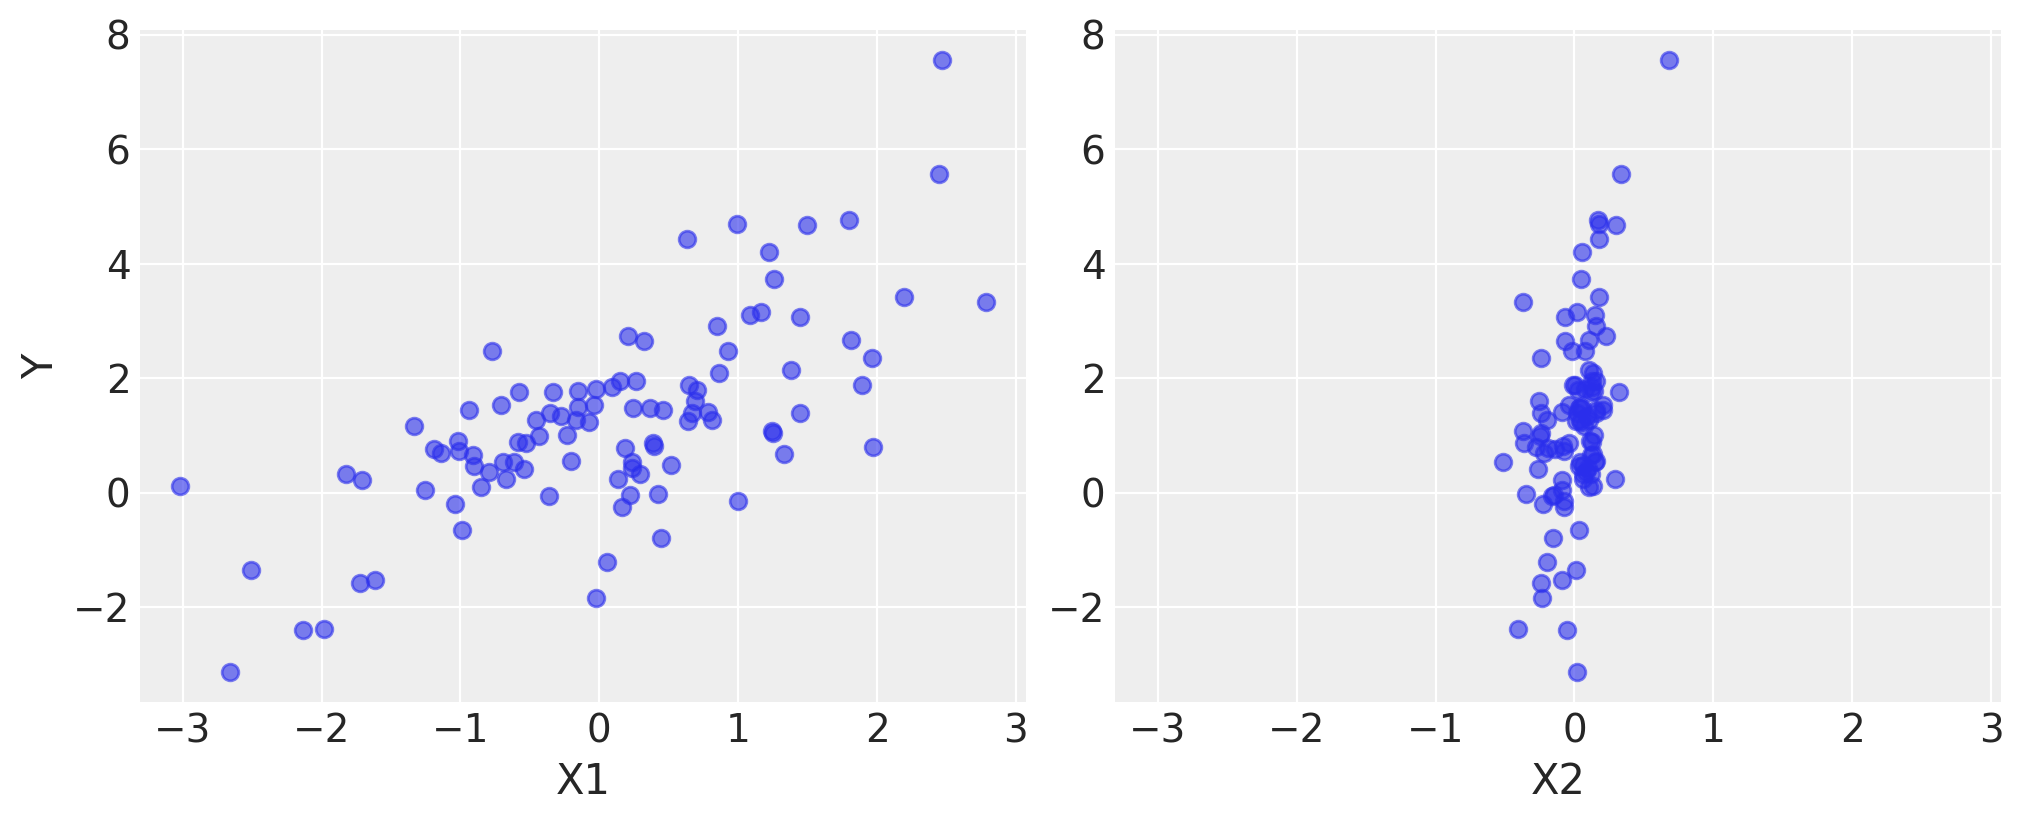

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

#### Model Setup in PyMC3

In [5]:
%pip install pymc pandas==1.3.5

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


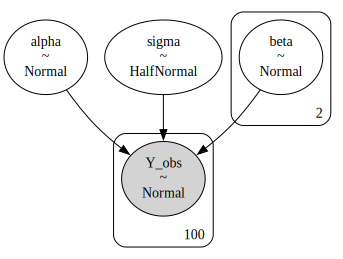

In [7]:
basic_model = pm.Model() # creates a new Model object which is a container for the model random variables.

with basic_model: # entrering context manager

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2 # This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. 

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
pm.model_to_graphviz(basic_model)

Note: Most commonly-used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, are available in PyMC.

### MAP Estimate¶


In [15]:
## Point estimates

from pymc import find_MAP

map_estimate = find_MAP(model=basic_model, maxeval=10000)
map_estimate

{'alpha': array(1.15827617),
 'beta': array([0.950158  , 3.80023114]),
 'sigma_log__': array(-0.04663664),
 'sigma': array(0.95443414)}

### Inference with PyMC

In [9]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

The various attributes of the InferenceData object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. For example, we can retrieve the sampling trace from the alpha latent variable by using the variable name as an index to the idata.posterior attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the alpha variable in each chain as follows:

In [11]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[0.9639148 , 1.39386849, 1.2712707 , 1.03057809, 1.24303576],
       [1.33474813, 1.28457757, 1.28457757, 1.28457757, 1.02127302],
       [1.10643221, 1.14258711, 1.18971103, 0.96668857, 1.1822093 ],
       [1.15737878, 1.19456802, 1.14765266, 1.12908387, 1.04405793]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [12]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 29 seconds.


### Posterior analysis

PyMC’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named Arviz. A simple posterior plot can be created using plot_trace.


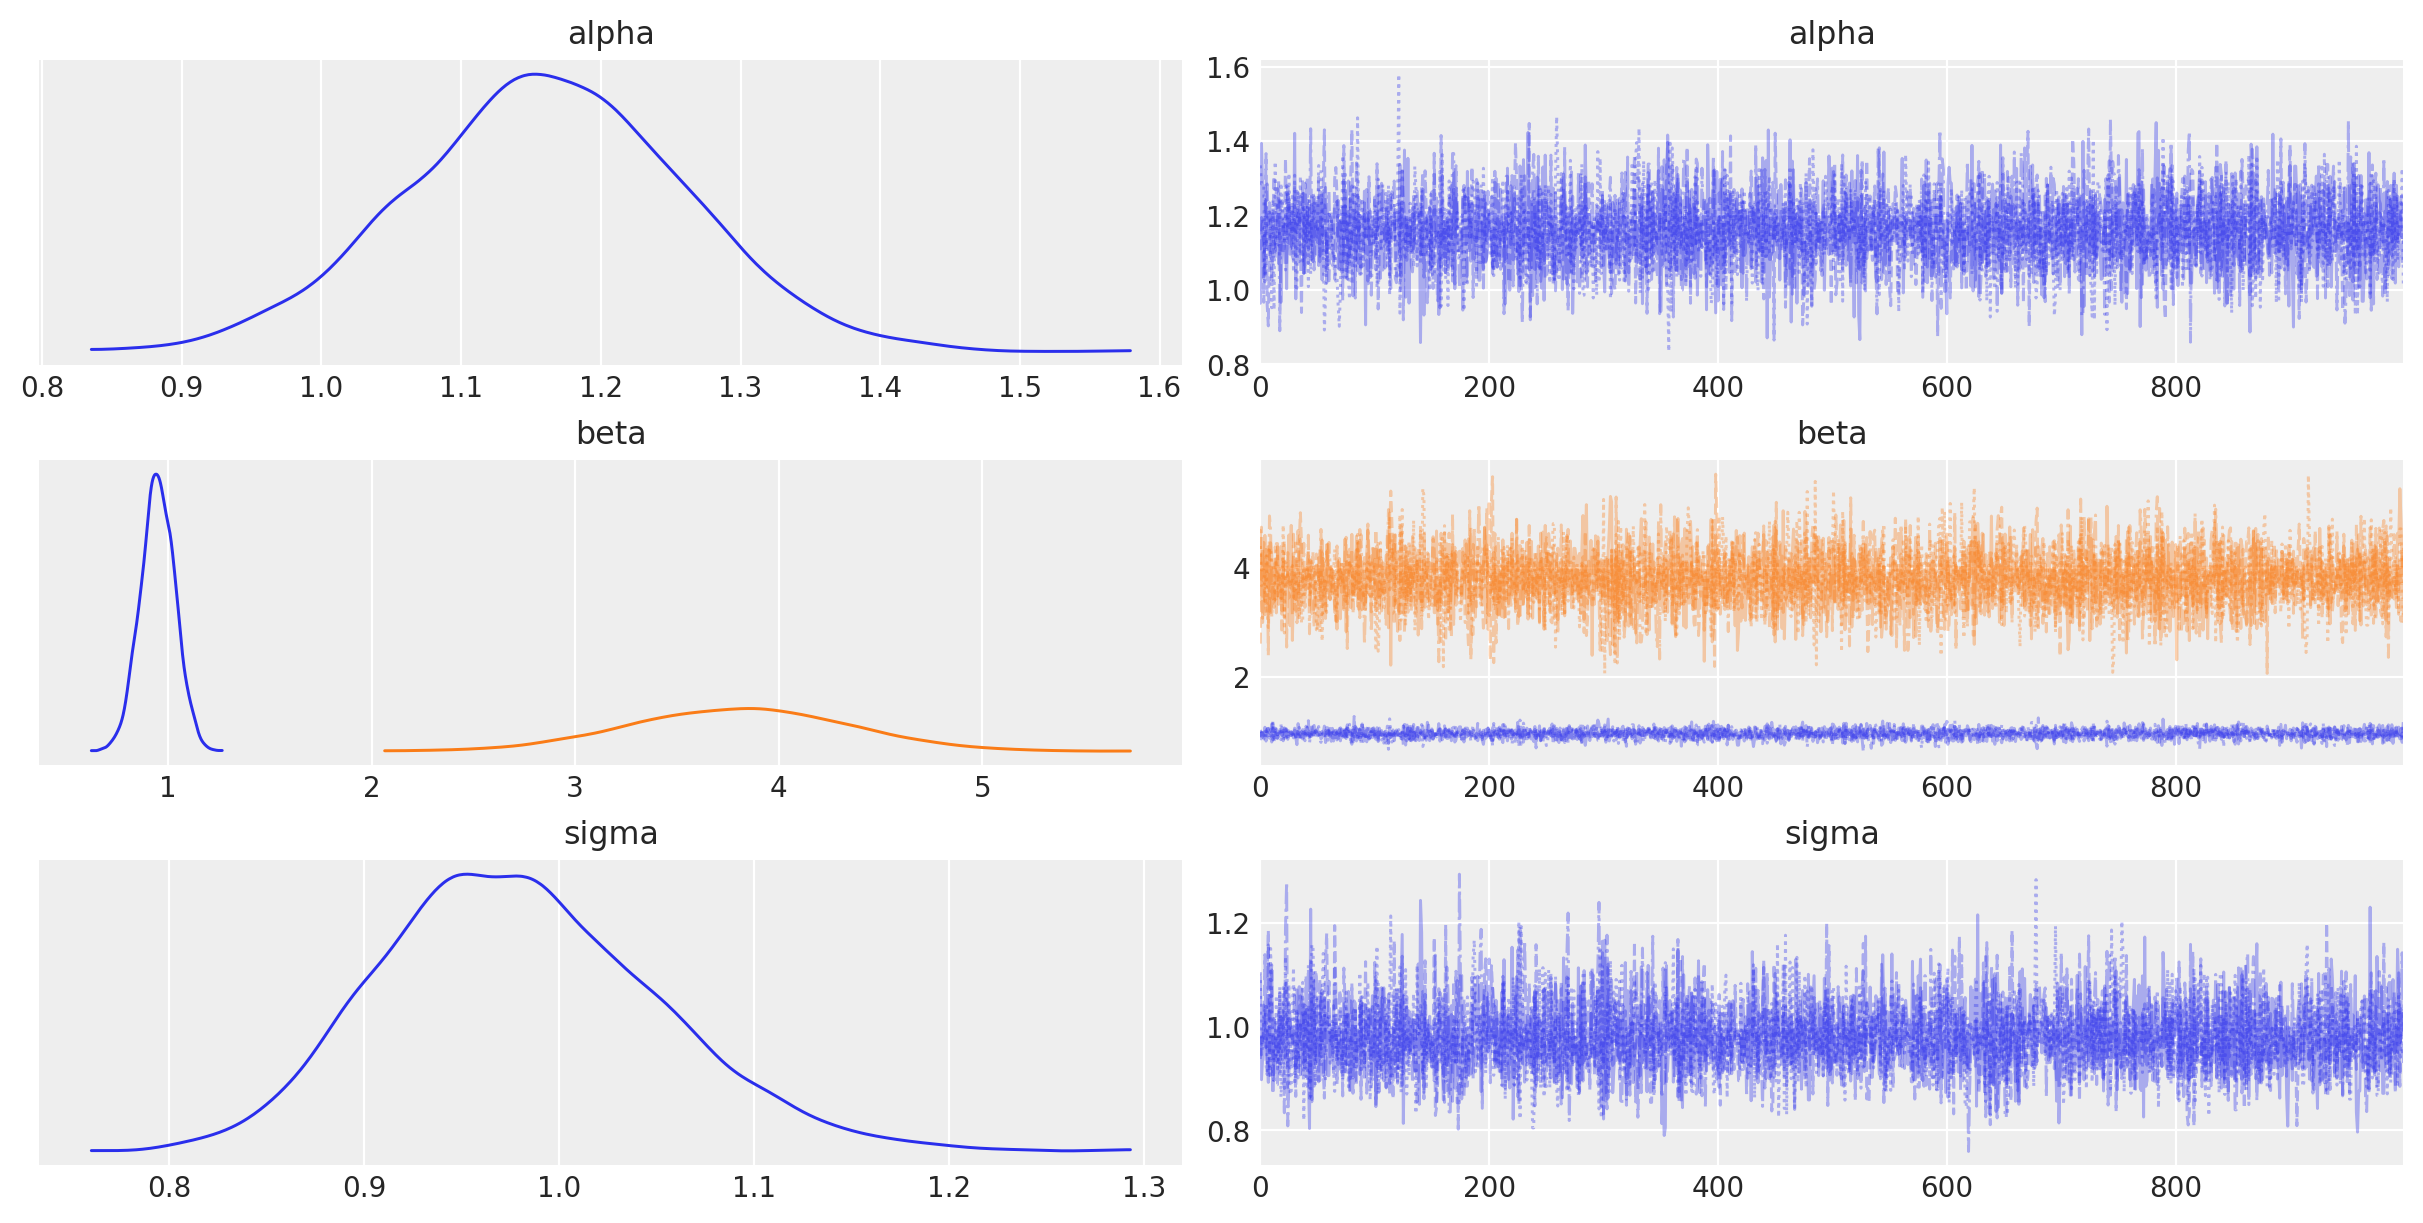

In [13]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In [14]:
az.summary(idata, round_to=2)

## True values for comparison
## alpha, sigma = 1, 1
## beta = [1, 2.5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.96,1.34,0.00,0.00,6818.41,3241.01,1.0
beta[0],0.95,0.09,0.80,1.12,0.00,0.00,5874.55,3288.87,1.0
beta[1],3.81,0.54,2.80,4.81,0.01,0.01,6177.04,2934.41,1.0
sigma,0.98,0.07,0.85,1.11,0.00,0.00,6051.78,2758.34,1.0
